In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# --- STEP 1: Load and feature engineer ---
df = pd.read_csv("nyc_taxi.csv", parse_dates=["t"])
df["c"] = df["c"].astype(np.float32)

# Seasonal features
df["dayofweek"] = df["t"].dt.dayofweek
df["month"] = df["t"].dt.month
df["dayofyear"] = df["t"].dt.dayofyear

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

# --- STEP 2: Use most recent N rows ---
N = 200
recent_df = df.tail(N).copy()
features = recent_df[["c", "dow_sin", "dow_cos", "month_sin", "month_cos", "doy_sin", "doy_cos"]].astype(np.float32).values
raw_counts = recent_df["c"].values  # for evaluation later

# --- STEP 3: Scale and split ---
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

train_end = int(0.7 * N)
val_end = int(0.9 * N)

train = features_scaled[:train_end]
val = features_scaled[train_end:val_end]
test = features_scaled[val_end:]

window_size = 30
forecast_horizon = 7
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- PyTorch Dataset ---
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, forecast_horizon):
        self.X, self.y = [], []
        for i in range(len(data) - window_size - forecast_horizon):
            x = data[i:i + window_size]
            y = data[i + window_size:i + window_size + forecast_horizon, 0]  # only "c"
            self.X.append(x)
            self.y.append(y)

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(train, window_size, forecast_horizon)
val_ds = TimeSeriesDataset(val, window_size, forecast_horizon)
test_ds = TimeSeriesDataset(test, window_size, forecast_horizon)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# --- TCN Model ---
class TCN(nn.Module):
    def __init__(self, input_size, forecast_horizon):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=2, dilation=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=4, dilation=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, forecast_horizon)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, features, time]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.global_pool(x).squeeze(-1)
        return self.fc(x)

model = TCN(input_size=features.shape[1], forecast_horizon=forecast_horizon).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# --- Training Loop ---
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            val_loss = sum(loss_fn(model(xb.to(device)), yb.to(device)).item() for xb, yb in val_loader)
        print(f"Epoch {epoch+1}: Val Loss = {val_loss / len(val_loader):.4f}")

train_model(model, train_loader, val_loader, epochs=100)

# --- Forecasting Helper ---
def forecast_next_n(model, raw_rows, window_size, scaler, forecast_horizon):
    model.eval()
    recent_window = raw_rows[-window_size:]
    recent_scaled = scaler.transform(recent_window).reshape(1, window_size, -1)
    with torch.no_grad():
        input_tensor = torch.tensor(recent_scaled, dtype=torch.float32).to(device)
        preds_scaled = model(input_tensor)[0].cpu().numpy()

    dummy_feats = recent_scaled[0, -1, 1:]
    unscaled_preds = []
    for p in preds_scaled:
        combined = np.concatenate([[p], dummy_feats])
        unscaled = scaler.inverse_transform(combined.reshape(1, -1))[0][0]
        unscaled_preds.append(unscaled)
    return unscaled_preds

tcn_forecast = forecast_next_n(model, features, window_size, scaler, forecast_horizon)
print("TCN Forecast:", tcn_forecast)


/var/folders/ks/drmb4skj4h13txr2xv35kk100000gn/T/ipykernel_23511/256703956.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


Epoch 1: Train Loss = 0.4156
Epoch 1: Val Loss = 0.4944
Epoch 2: Train Loss = 0.2446
Epoch 2: Val Loss = 0.3575
Epoch 3: Train Loss = 0.1028
Epoch 3: Val Loss = 0.2102
Epoch 4: Train Loss = 0.0377
Epoch 4: Val Loss = 0.1057
Epoch 5: Train Loss = 0.0595
Epoch 5: Val Loss = 0.0809
Epoch 6: Train Loss = 0.0633
Epoch 6: Val Loss = 0.0991
Epoch 7: Train Loss = 0.0462
Epoch 7: Val Loss = 0.1248
Epoch 8: Train Loss = 0.0376
Epoch 8: Val Loss = 0.1348
Epoch 9: Train Loss = 0.0329
Epoch 9: Val Loss = 0.1234
Epoch 10: Train Loss = 0.0263
Epoch 10: Val Loss = 0.0984
Epoch 11: Train Loss = 0.0208
Epoch 11: Val Loss = 0.0732
Epoch 12: Train Loss = 0.0195
Epoch 12: Val Loss = 0.0575
Epoch 13: Train Loss = 0.0192
Epoch 13: Val Loss = 0.0525
Epoch 14: Train Loss = 0.0172
Epoch 14: Val Loss = 0.0528
Epoch 15: Train Loss = 0.0151
Epoch 15: Val Loss = 0.0518
Epoch 16: Train Loss = 0.0135
Epoch 16: Val Loss = 0.0467
Epoch 17: Train Loss = 0.0123
Epoch 17: Val Loss = 0.0399
Epoch 18: Train Loss = 0.0116
Ep

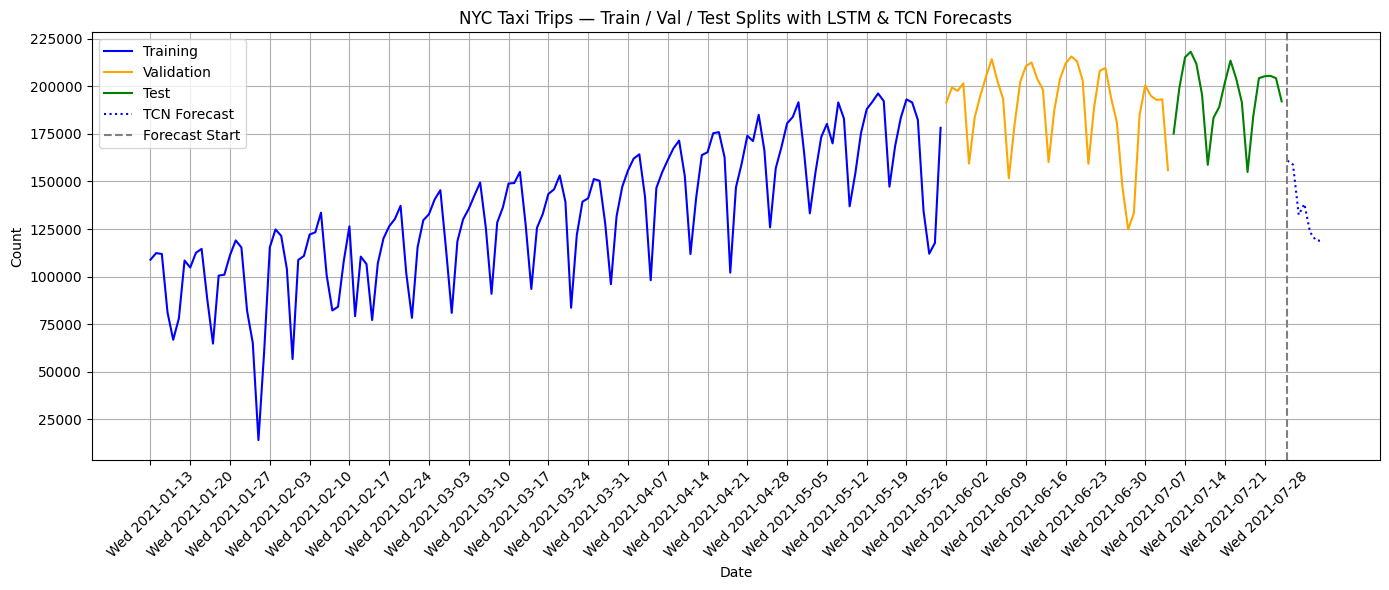

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# --- Plot train/val/test data with LSTM and TCN forecasts overlaid ---
plt.figure(figsize=(14, 6))

time_steps = np.arange(len(recent_df))
counts = recent_df["c"].values
dates = recent_df["t"].values

train_end = int(0.7 * len(counts))
val_end = int(0.9 * len(counts))
forecast_start = len(counts)
forecast_range = range(forecast_start, forecast_start + forecast_horizon)

# Plot historical data
plt.plot(time_steps[:train_end], counts[:train_end], label='Training', color='blue')
plt.plot(time_steps[train_end:val_end], counts[train_end:val_end], label='Validation', color='orange')
plt.plot(time_steps[val_end:], counts[val_end:], label='Test', color='green')

# Overlay forecasts
# plt.plot(forecast_range, lstm_forecast, 'r:', label='LSTM Forecast')
plt.plot(forecast_range, tcn_forecast, 'b:', label='TCN Forecast')

plt.title("NYC Taxi Trips — Train / Val / Test Splits with LSTM & TCN Forecasts")

# Format x-axis with only Mondays
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))

# X-ticks from actual datetime series
xticks = np.arange(0, len(dates), 7)
xtick_labels = pd.to_datetime(dates[xticks]).strftime('%a %Y-%m-%d')
plt.xticks(xticks, xtick_labels, rotation=45)

# Forecast boundary
plt.axvline(x=forecast_start, color='grey', linestyle='--', label='Forecast Start')

plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
